# Numerical differentiation of noisy data: A unifying multi-objective optimization framework

This notebook builds on `1_basic_tutorial.ipynb` by calling optimization routines to find optimal parameters for each method.

### Notations:
  * dt: (float) time step (note: we concentrated on differentiating timeseries data, however these functions work for a 1-dimensional spatial derivative as well)
  * x: (np.array with length N) the time series you want to differentiate
  * x_hat: (np.array with length N) the smoothed estimate of x
  * x_truth: (np.array with length N) the true value of x (which is known when the data is simulated, and used for plotting purposes only)
  * dxdt_hat: (np.array with length N) the estimate of the derivative of x
  * dxdt_truth: (np.array with length N) the true value of dxdt (which is known when the data is simulated, and used for plotting purposes only)

In [1]:
import numpy as np
import os, sys
# local import
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from pynumdiff.optimize import optimize
from pynumdiff.utils import evaluate
from pynumdiff.utils.simulate import sine, triangle, pop_dyn, linear_autonomous,\
	pi_control, lorenz_x
from pynumdiff.finite_difference import first_order, second_order
from pynumdiff.smooth_finite_difference import mediandiff, meandiff, gaussiandiff,\
    friedrichsdiff, butterdiff, splinediff
from pynumdiff.total_variation_regularization import velocity, acceleration,\
	jerk, iterative_velocity, smooth_acceleration
from pynumdiff.linear_model import spectraldiff, polydiff, savgoldiff, lineardiff
from pynumdiff.kalman_smooth import constant_velocity, constant_acceleration, constant_jerk

# 0. Simulate some data

pynumdiff comes with 6 different toy problems (choose the one that most resembles your data to see how the methods compare):
* lorenz_x: (nonlinear) x component of a lorenz attractor
* sine: (linear) sum of two sines
* pop_dyn: (nonlinear) bounded exponential growth
* triangle: (nonlinear) sharp-edged triangle wave with increasing frequency
* pi_control: (linear / nonlinear) linear proportional integral controller with nonlinear control inputs

In [2]:
# noise is generated using np.random, e.g. np.random.normal, np.random.uniform, np.random.poisson
# noise_type and noise_parameters should be compatible with np.random functions 
noise_type = 'normal'
noise_parameters = [0, 0.1]

# time step and time series length
dt = 0.01 # sampling time step
duration = 4 # sec
problem = pi_control

In [3]:
x, x_truth, dxdt_truth, extras = problem(duration, 
                                        noise_parameters=noise_parameters, 
                                        dt=dt)

For our toy problems we can optimize the parameters in one of two options:
1. Use the known dxdt to find the best parameters 
2. Actual dxdt is unknown

In the real world, option (1) is not possible, so this notebook focuses on case (2). For the first case, see notebook 2a.

The optimization approach described here solves a loss function that balances the faithfulness and smoothness of the derivative estimate, and relies on a single hyperparameter, $\gamma$, or `tvgamma` in the code. See the paper for more detail, but a brief overview is given here.

The loss function to find the optimal parameters is as follows,

$$L = \text{RMSE} \bigg( \text{trapz}(\mathbf{\hat{\dot{x}}}(\Phi)) + \mu, \mathbf{y} \bigg) + \gamma \bigg({TV}\big(\mathbf{\hat{\dot{x}}}(\Phi)\big)\bigg),$$
where $\mathbf{y}$ are the noisy measurements, $\mathbf{\hat{\dot{x}}}$ is the estimate of the derivative, $\text{trapz}(\cdot)$ is the discrete-time trapezoidal numerical integral, $\mu$ resolves the unknown integration constant, $\gamma$ is a hyper-parameter, and $TV$ is the total variation,

$$TV(\mathbf{\hat{\dot{x}}}) = \frac{1}{m}\left\lVert\mathbf{\hat{\dot{x}}}_{0:m-1}-\mathbf{\hat{\dot{x}}}_{1:m}\right\rVert_{1}.$$

To use the code to  solve the loss function and find your optimal parameters is quite simple.

First, find tvgamma using the following heuristic: 

In [4]:
cutoff_frequency = 3 # high frequency of signal in the data. 
# estimate by (a) counting real # peaks per second in the data or (b) look at power spectrum and choose cutoff. 
log_gamma = -1.6*np.log(cutoff_frequency) -0.71*np.log(dt) - 5.1
tvgamma = np.exp(log_gamma)      

Use the following syntax, as detailed in the notebook:

```python
from pynumdiff.optimize import optimize
from pynumdiff.module import method

search_space = {'param1':[values], 'param2':[values], ...}

params, val = optimize(method, x, dt, search_space, 
                    tvgamma=tvgamma, # hyperparameter
                    dxdt_truth=dxdt_truth) # defaults to None if no ground truth data
   
x_hat, dxdt_hat = method(x, dt, **params)
```

where `param`s are keyword arguments that come from the method definition. If you don't know a search space, default search spaces are defined for all methods in `optimize.py`. Partial search spaces are accepted, simply `.update`d to the default search space. Reasonable upper and lower bounds are defined for numerical search space dimensions (type `int` or `float`). Data type `bool` can also be searched over, but searching over `str` parameters is currently not supported.

## 1. Finite Difference

### 1.1 Finite Difference: Iterated First Order

(This is actually currently second order, per #104)

Optimal parameters:  {'num_iterations': 14}
RMS error in velocity:  1.162023472811752


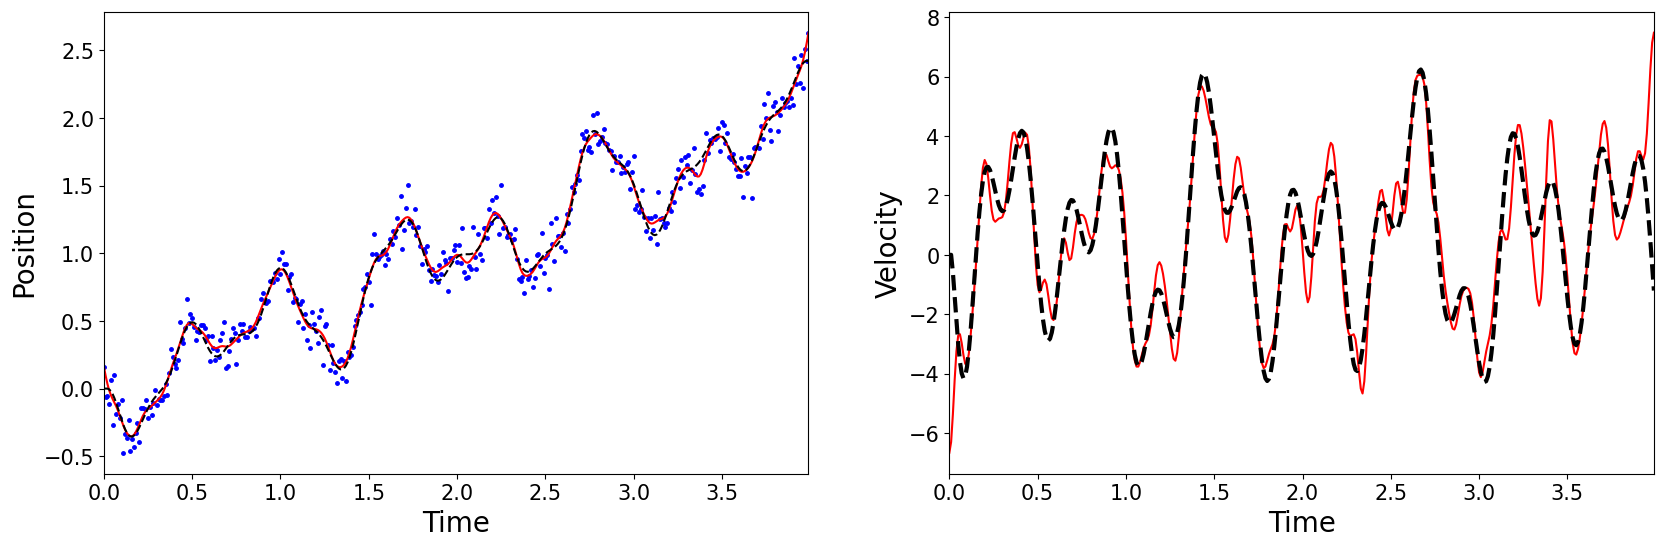

In [5]:
params, val = optimize(first_order, x, dt, tvgamma=tvgamma)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = first_order(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

## 2. Smooth Finite Difference

### 2.1 Smooth Finite Difference: Median smoothing

Optimal parameters:  {'window_size': 12, 'num_iterations': 6}
RMS error in velocity:  1.702147871795821


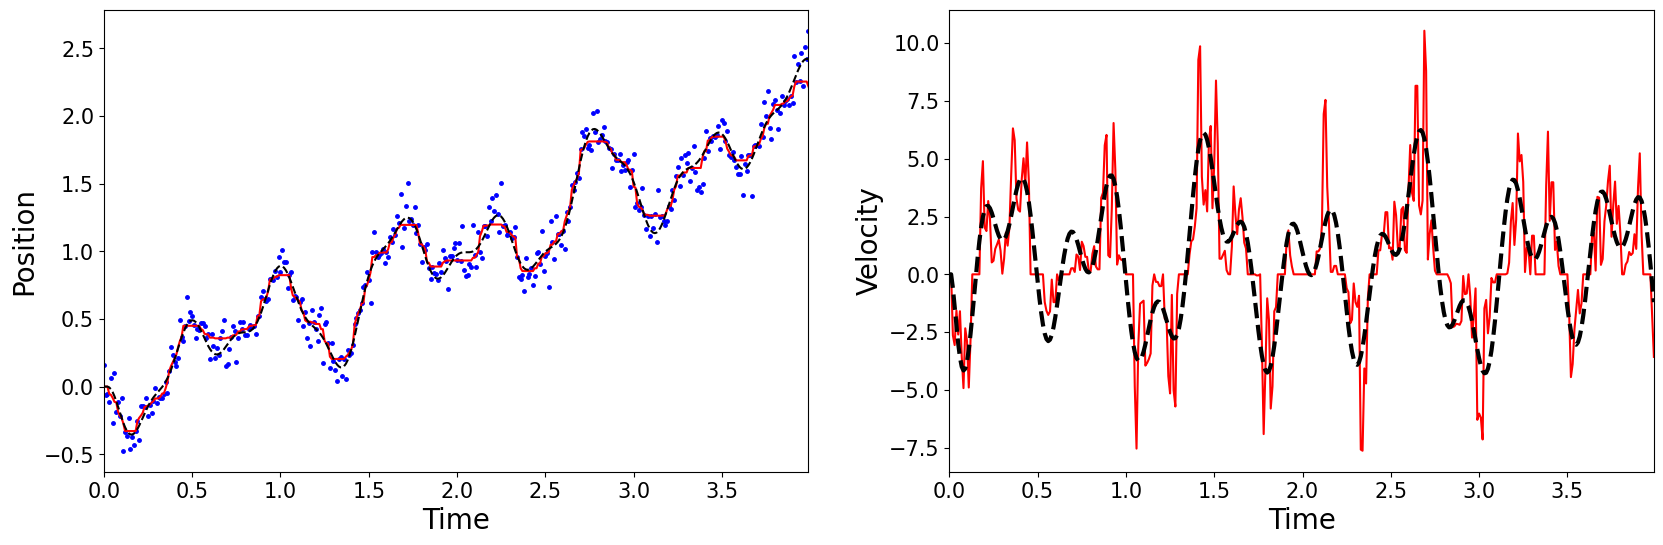

In [6]:
params, val = optimize(mediandiff, x, dt, tvgamma=tvgamma)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = mediandiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 2.2 Smooth Finite Difference: Mean smoothing

Optimal parameters:  {'window_size': 3, 'num_iterations': 8}
RMS error in velocity:  0.9584229201580386


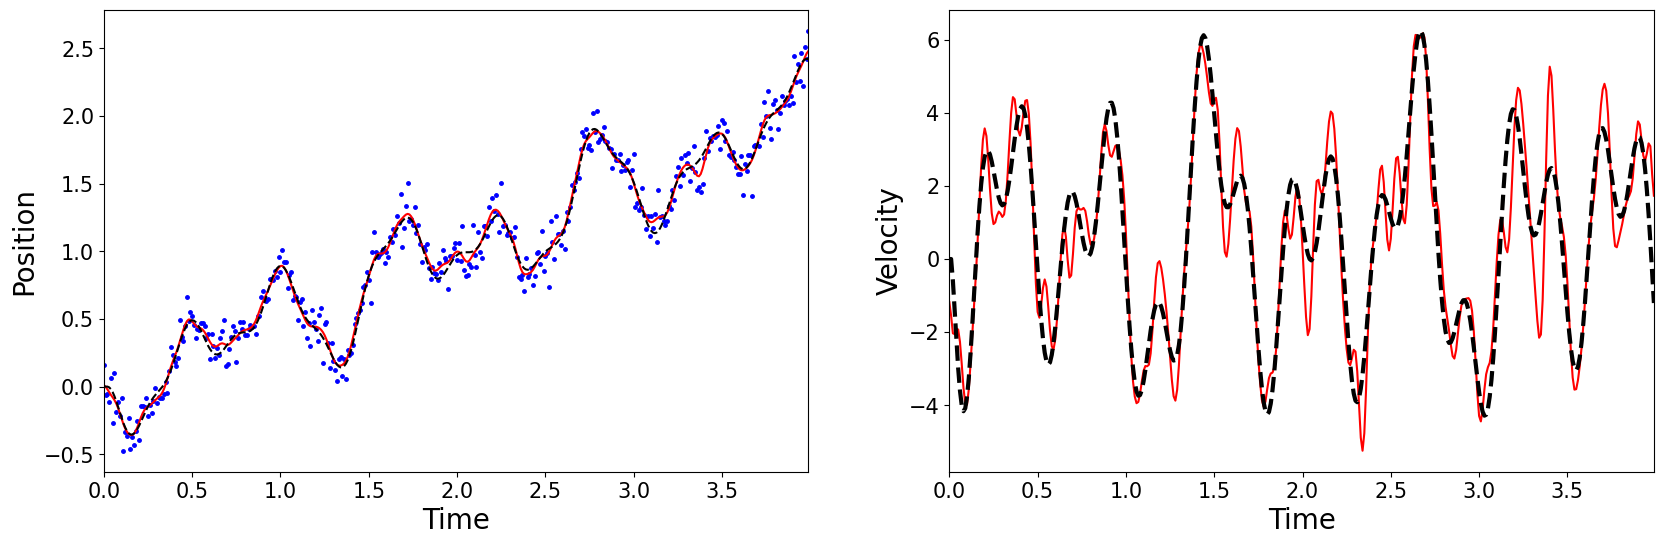

In [7]:
params, val = optimize(meandiff, x, dt, tvgamma=tvgamma)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = meandiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 2.3 Smooth Finite Difference: Gaussian smoothing

Optimal parameters:  {'window_size': 15, 'num_iterations': 1}
RMS error in velocity:  0.8438151181174117


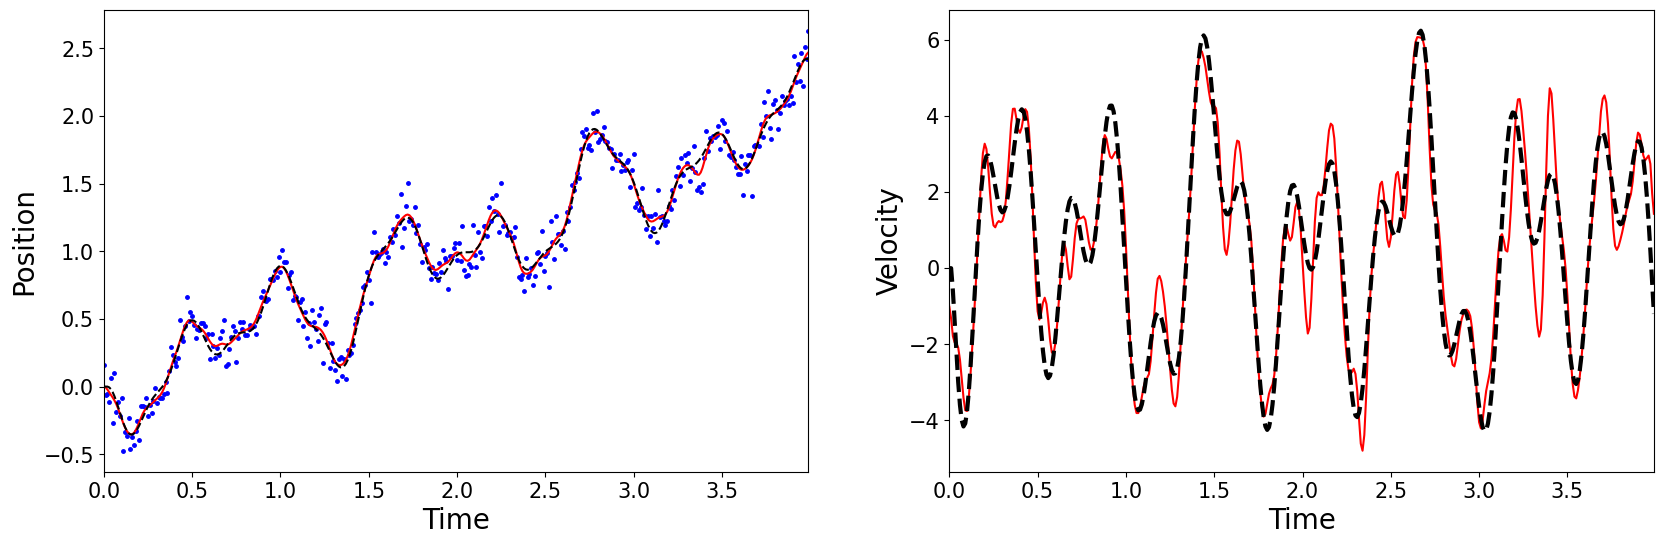

In [8]:
params, val = optimize(gaussiandiff, x, dt, tvgamma=tvgamma)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = gaussiandiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 2.4 Smooth Finite Difference: Friedrichs smoothing

Optimal parameters:  {'window_size': 5, 'num_iterations': 10}
RMS error in velocity:  0.9020232157505415


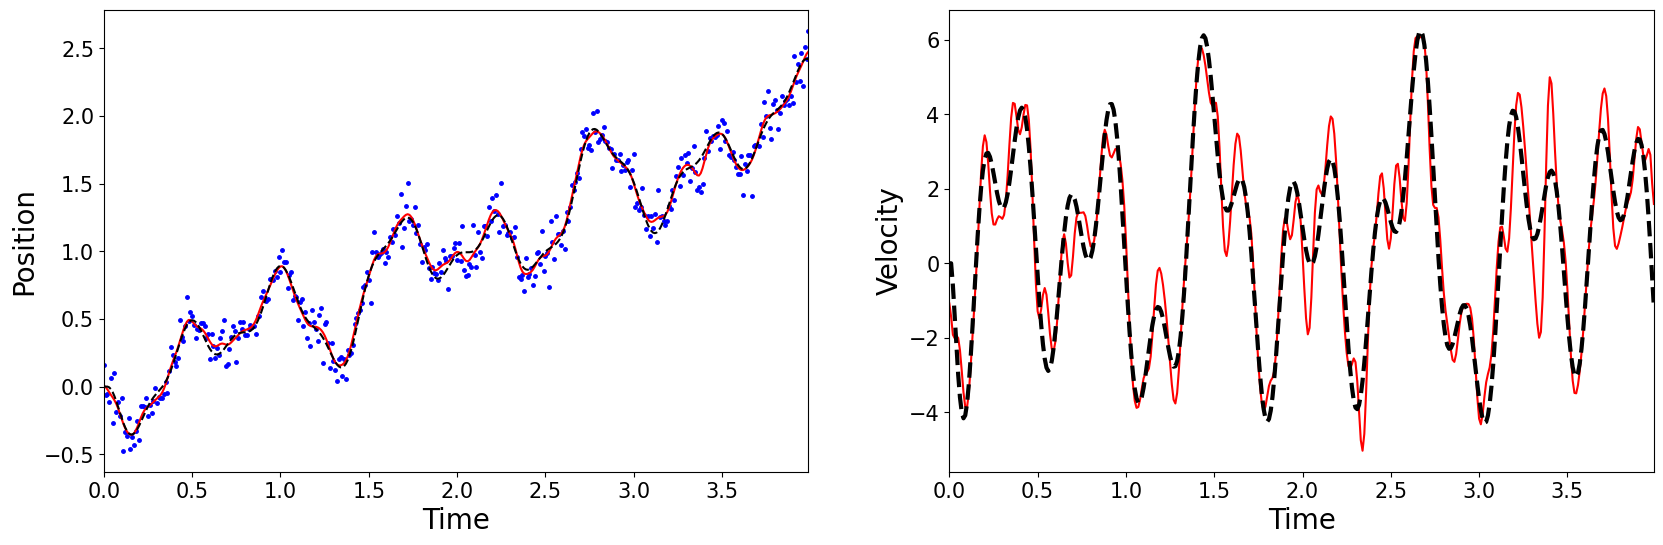

In [9]:
params, val = optimize(friedrichsdiff, x, dt, tvgamma=tvgamma)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = friedrichsdiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 2.5 Smooth Finite Difference: Butterworth smoothing

Optimal parameters:  {'filter_order': 2, 'cutoff_freq': np.float64(0.1316666666666667), 'num_iterations': 1}
RMS error in velocity:  1.113928026641252


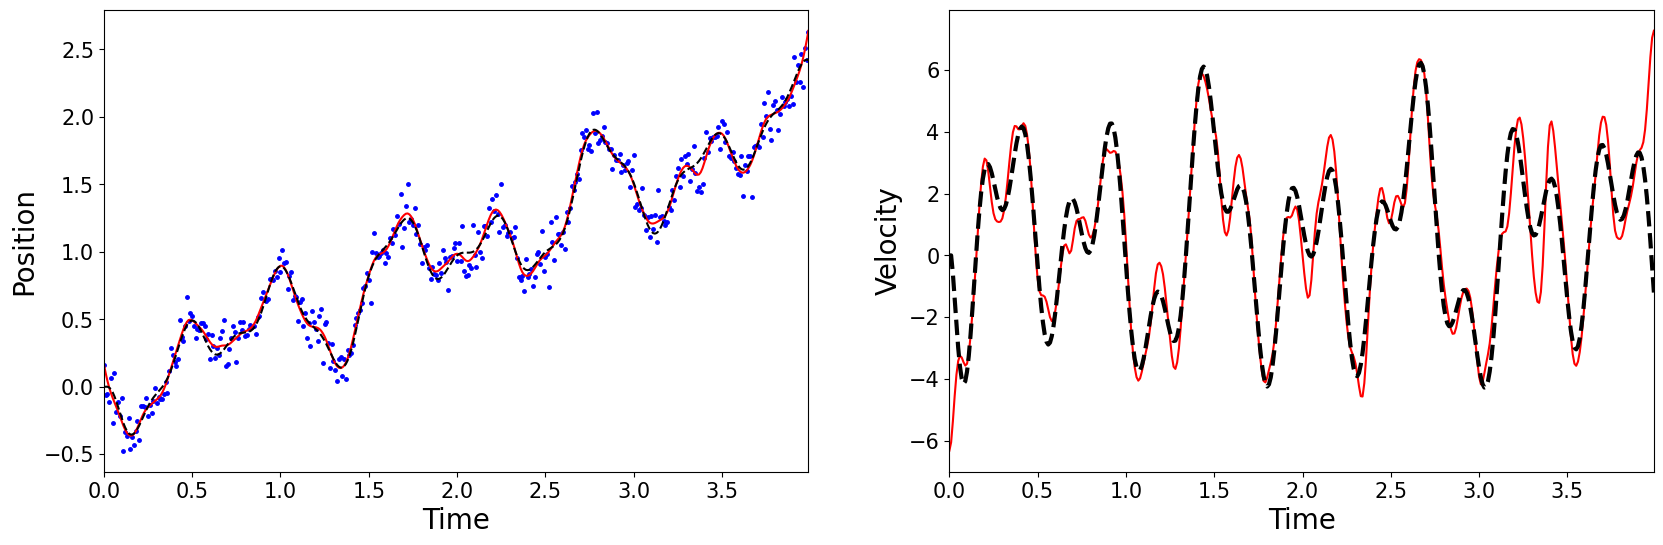

In [10]:
params, val = optimize(butterdiff, x, dt, tvgamma=tvgamma)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = butterdiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 2.6 Smooth Finite Difference: Spline smoothing

Optimal parameters:  {'order': 5, 's': np.float64(0.5238136574074074), 'num_iterations': 5}
RMS error in velocity:  1.2802706509210833


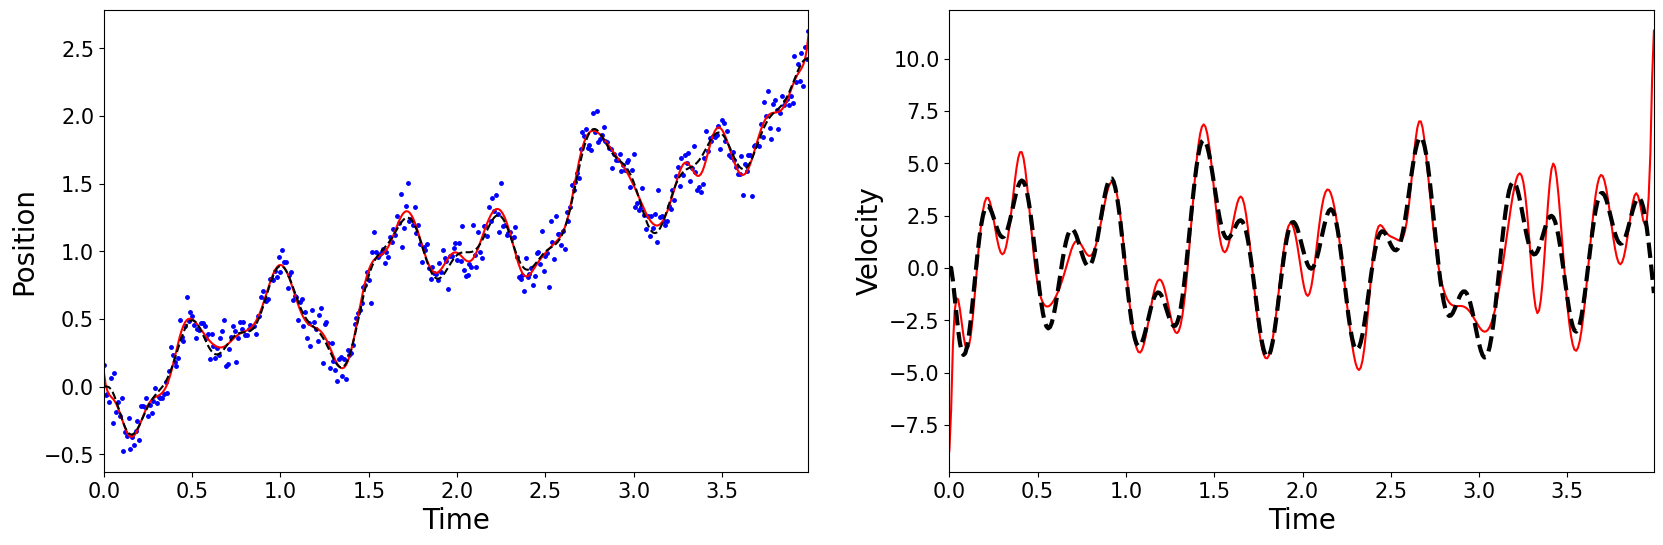

In [11]:
params, val = optimize(splinediff, x, dt, tvgamma=tvgamma)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = splinediff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

## 3. Total Variation Regularization

### 3.1 Iterative Total Variation Regularization (regularized velocity)

Optimal parameters:  {'num_iterations': 5, 'gamma': np.float64(0.0014999999999999875), 'scale': 'small'}
RMS error in velocity:  1.2014249483880401


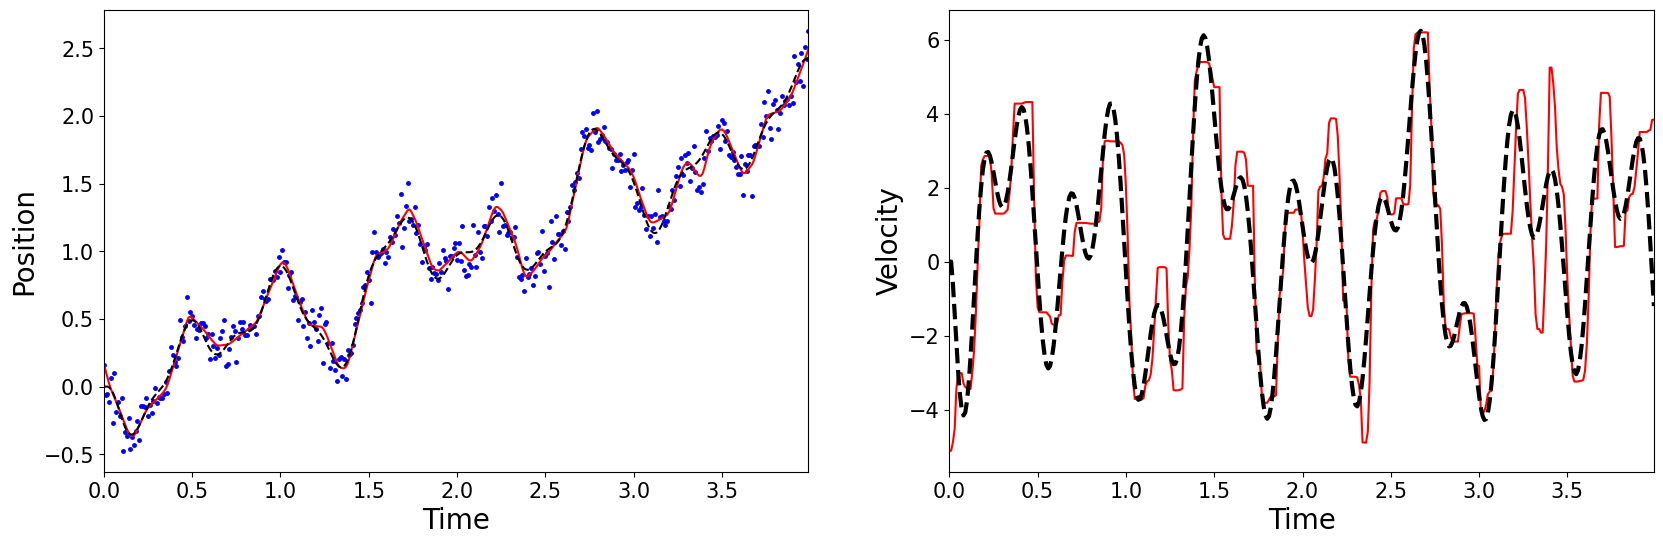

In [12]:
params, val = optimize(iterative_velocity, x, dt, search_space={'num_iterations': [1, 2, 3]}, tvgamma=tvgamma)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = iterative_velocity(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 3.2 Convex Total Variation Regularization: regularize velocity

Optimal parameters:  {'gamma': np.float64(0.7570312499999998)}
RMS error in velocity:  1.1170373715900346


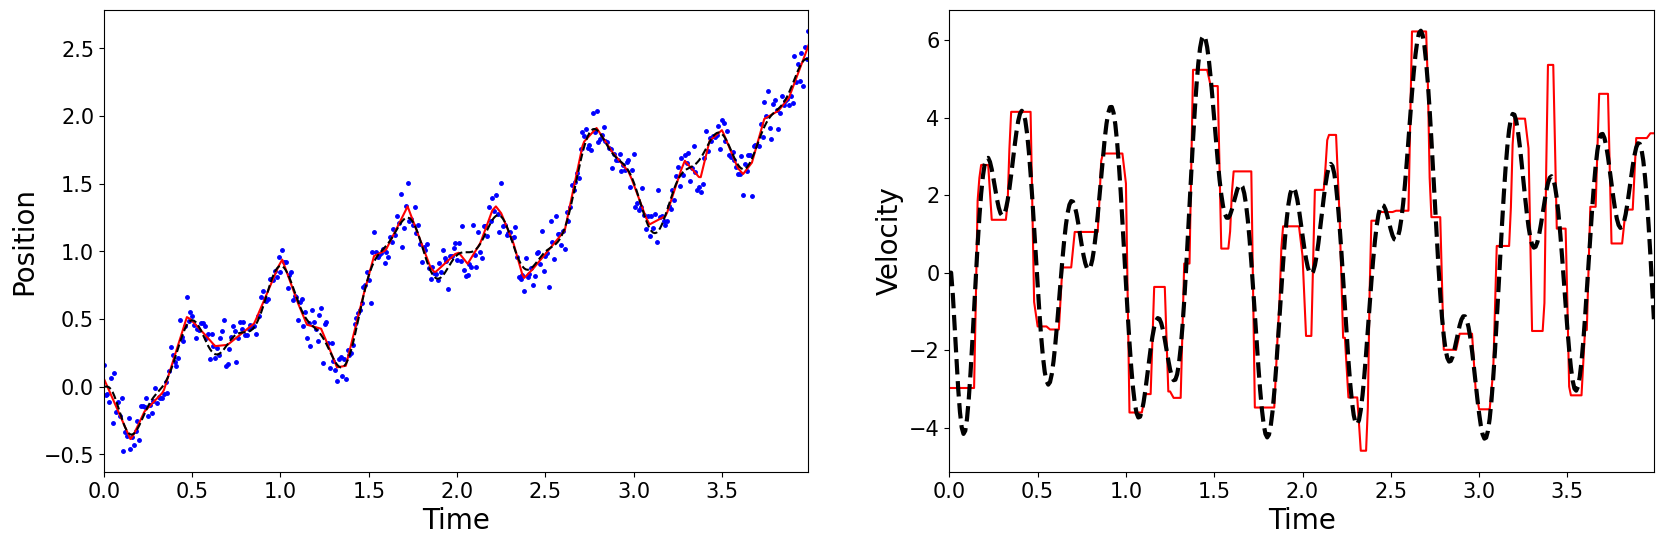

In [13]:
params, val = optimize(velocity, x, dt, tvgamma=tvgamma)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = velocity(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 3.3 Convex Total Variation Regularization: regularize acceleration

Optimal parameters:  {'gamma': np.float64(1.2150000000000043)}
RMS error in velocity:  0.9837672890950037


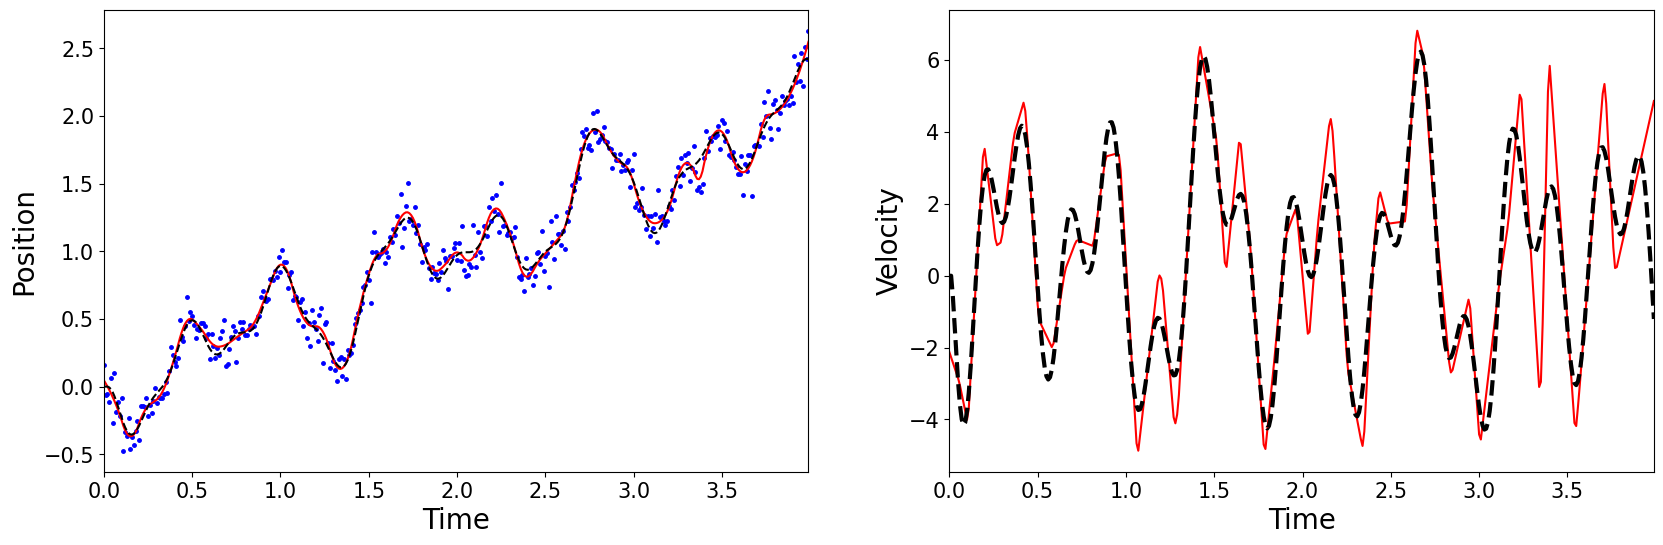

In [14]:
params, val = optimize(acceleration, x, dt, tvgamma=tvgamma)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = acceleration(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 3.4 Convex Total Variation Regularization: regularize jerk

Optimal parameters:  {'gamma': np.float64(8.80859375)}
RMS error in velocity:  0.7943682952240263


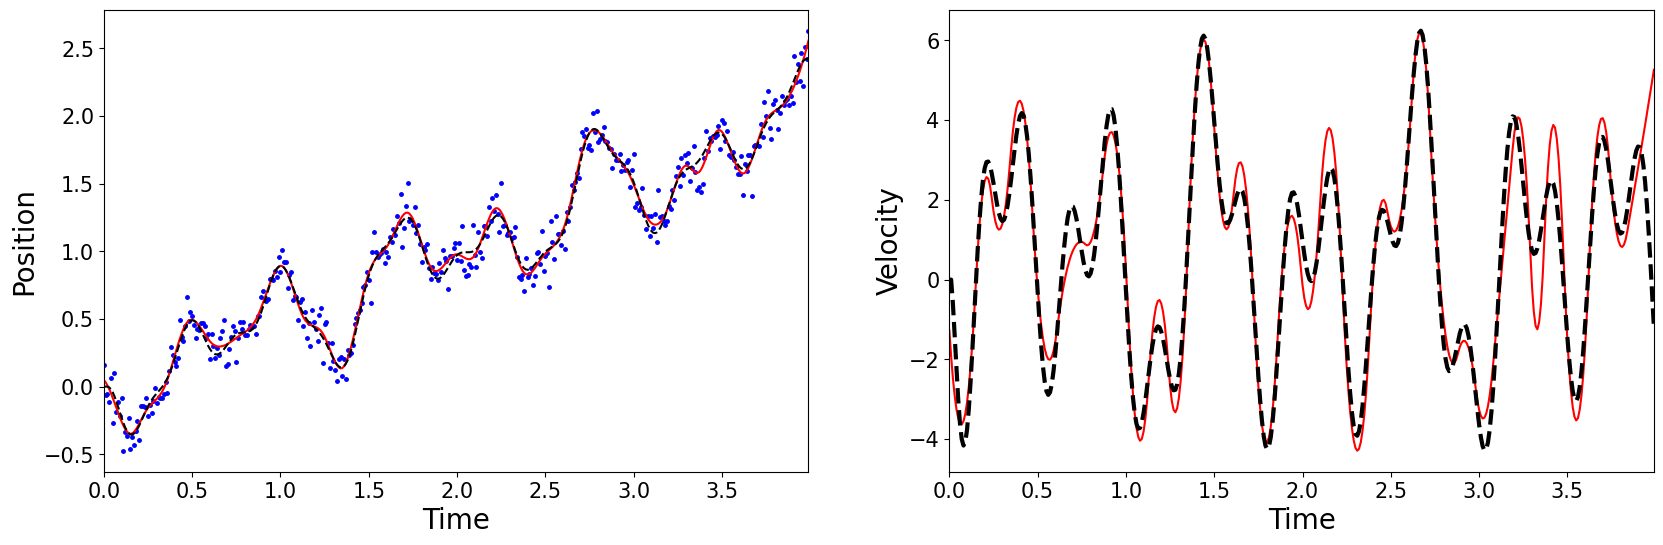

In [15]:
params, val = optimize(jerk, x, dt, tvgamma=tvgamma)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = jerk(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 3.5 Convex Total Variation Regularization: regularize acceleration with gaussian smoothing

Optimal parameters:  {'gamma': np.float64(0.8249999999999995), 'window_size': 10}
RMS error in velocity:  0.9603804267933025


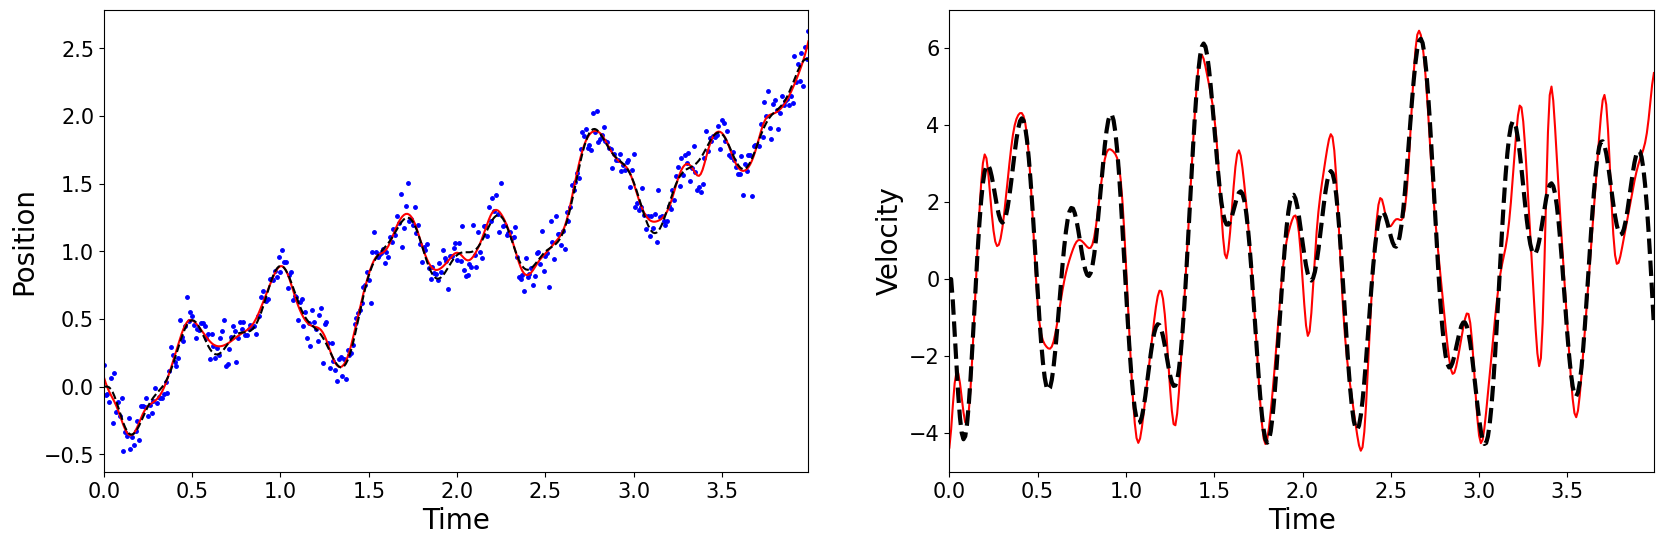

In [16]:
params, val = optimize(smooth_acceleration, x, dt, tvgamma=tvgamma)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = smooth_acceleration(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

## 4. Linear Models

### 4.1 Linear Models: Spectral derivative

Optimal parameters:  {'even_extension': np.True_, 'pad_to_zero_dxdt': np.True_, 'high_freq_cutoff': np.float64(0.07502057613168726)}
RMS error in velocity:  1.006170972315387


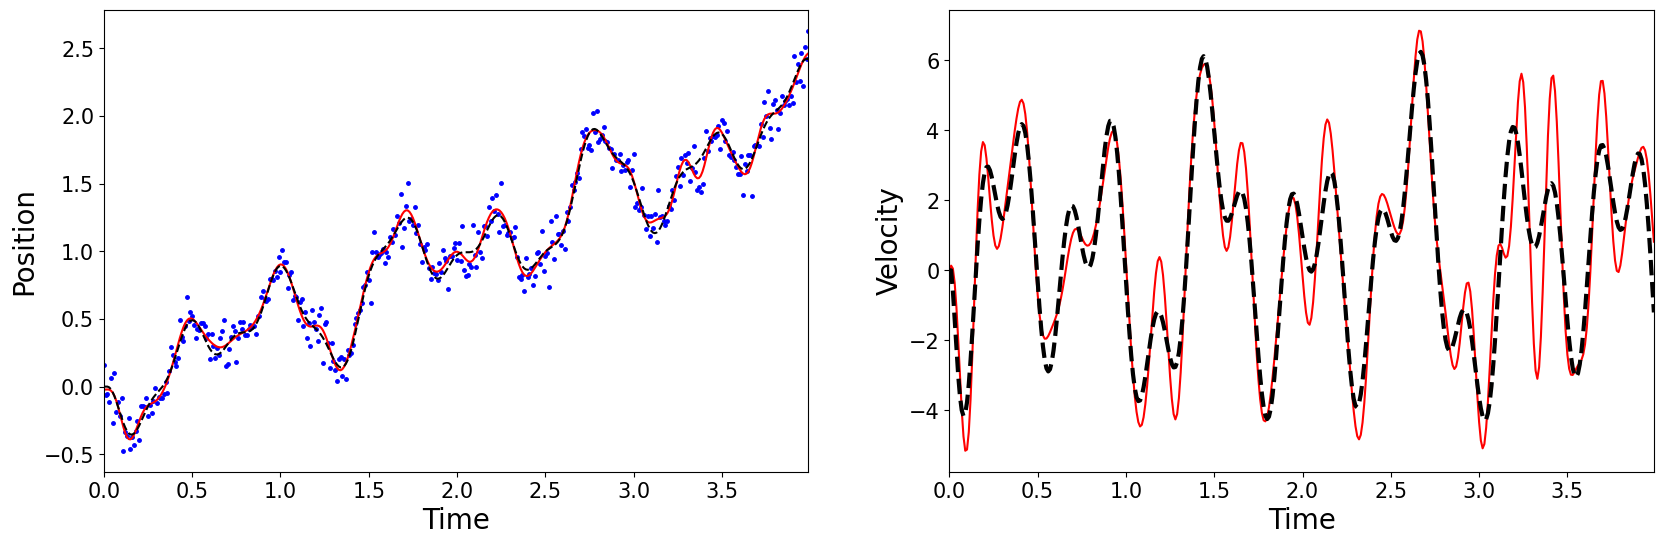

In [17]:
params, val = optimize(spectraldiff, x, dt,
                       search_space={'even_extension': [True, False], 'pad_to_zero_dxdt': [True, False]},
                       tvgamma=tvgamma)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = spectraldiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 4.2 Linear Models: Sliding polynomial fit

Optimal parameters:  {'step_size': 1, 'poly_order': 2, 'window_size': 27, 'kernel': 'friedrichs'}
RMS error in velocity:  0.7532273187764686


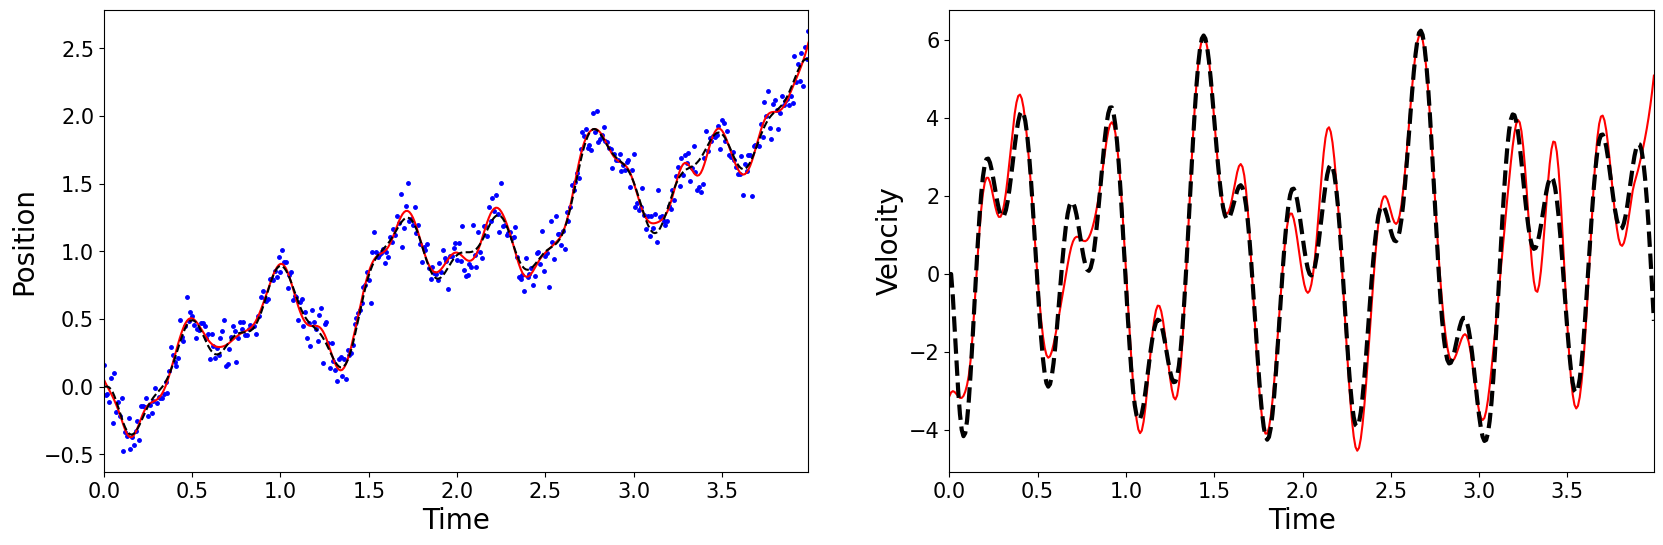

In [18]:
params, val = optimize(polydiff, x, dt, search_space={'step_size':[1, 2, 5]}, tvgamma=tvgamma)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = polydiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 4.3 Linear Models: Savitzky-Golay filter

Optimal parameters:  {'poly_order': 4, 'window_size': 12, 'smoothing_win': 14}
RMS error in velocity:  1.3808848154061322


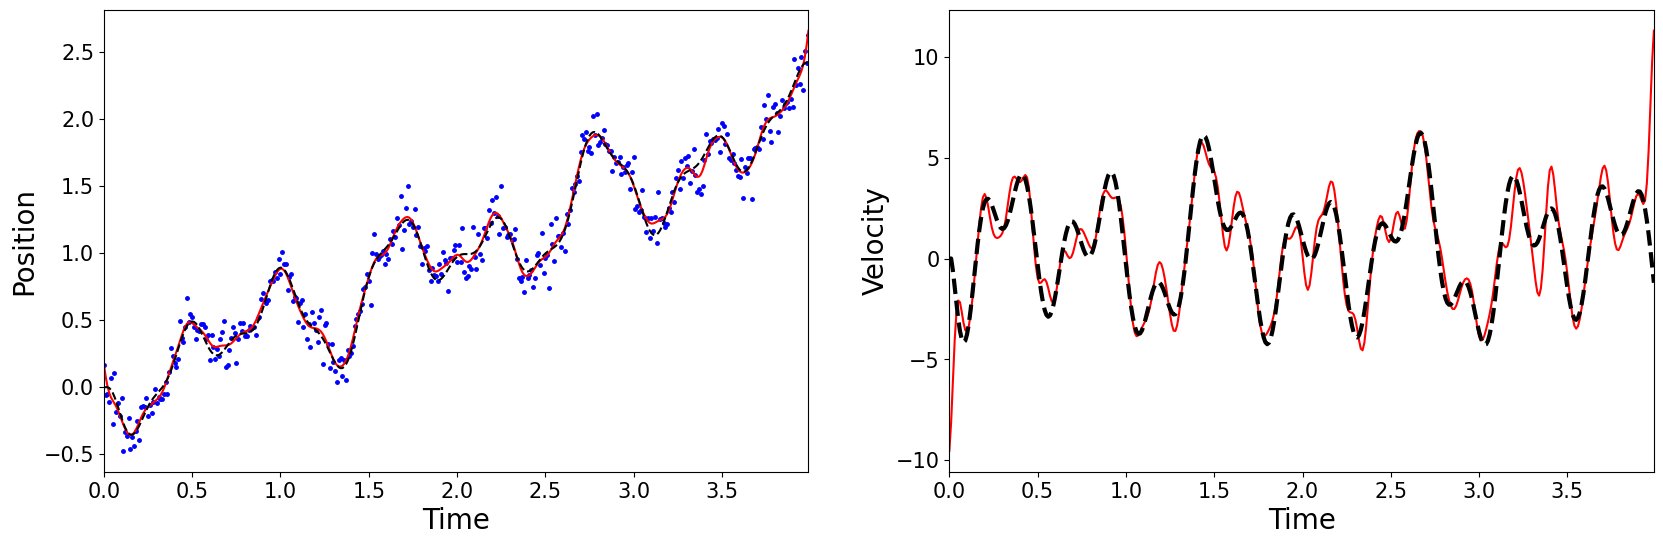

In [19]:
params, val = optimize(savgoldiff, x, dt, tvgamma=tvgamma)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = savgoldiff(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 4.4 Linear Models: Sliding chebychev polynomial fit - removed to simplify requirements

### 4.5 Linear Models: Sliding linear time invariant system fit

In [20]:
if 0: # this one is too slow and runtime error prone!
    params, val = optimize(lineardiff, x, dt, tvgamma=tvgamma)
    print('Optimal parameters: ', params)
    x_hat, dxdt_hat = lineardiff(x, dt, **params)
    evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

## Kalman smoothing

### 5.1 Kalman smoothing: constant velocity

Optimal parameters:  {'forwardbackward': np.True_, 'q': np.float64(12.666666666666657), 'r': np.float64(0.0533333333333334)}
RMS error in velocity:  0.8492367199504128


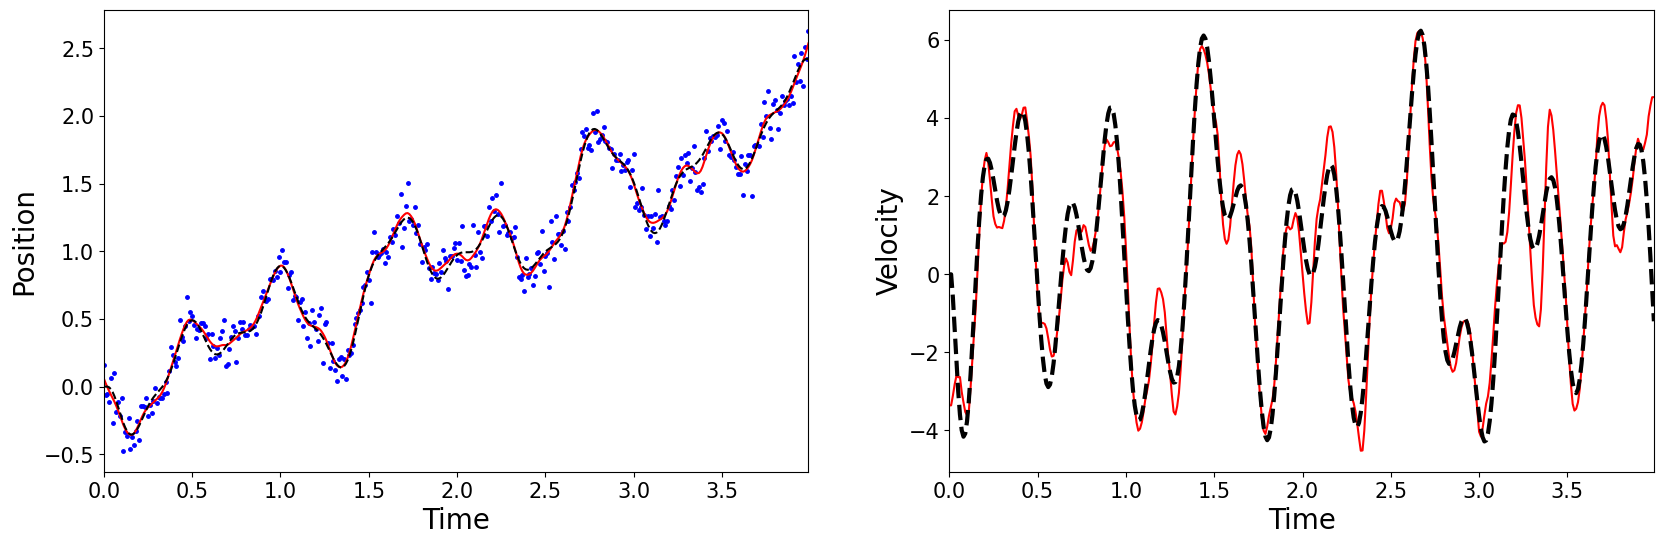

In [21]:
params, val = optimize(constant_velocity, x, dt, search_space={'forwardbackward': [True, False]}, tvgamma=tvgamma)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = constant_velocity(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 5.2 Kalman smoothing: constant acceleration

Optimal parameters:  {'forwardbackward': np.False_, 'q': np.float64(15.16666666666665), 'r': np.float64(2.333333333333335e-05)}
RMS error in velocity:  0.970063934726473


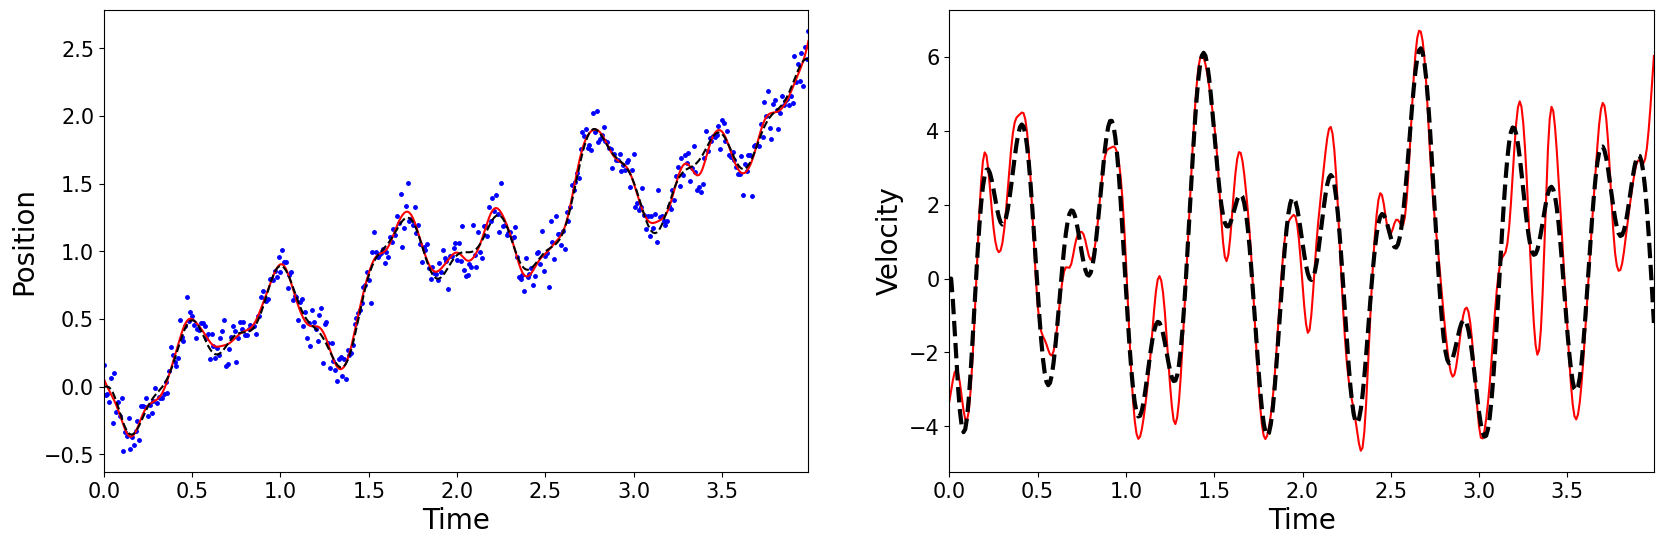

In [22]:
params, val = optimize(constant_acceleration, x, dt, search_space={'forwardbackward': [True, False]}, tvgamma=tvgamma)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = constant_acceleration(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)

### 5.3 Kalman smoothing: constant jerk

Optimal parameters:  {'forwardbackward': np.False_, 'q': np.float64(121944444.44444436), 'r': np.float64(0.06098765432098771)}
RMS error in velocity:  1.092984368449755


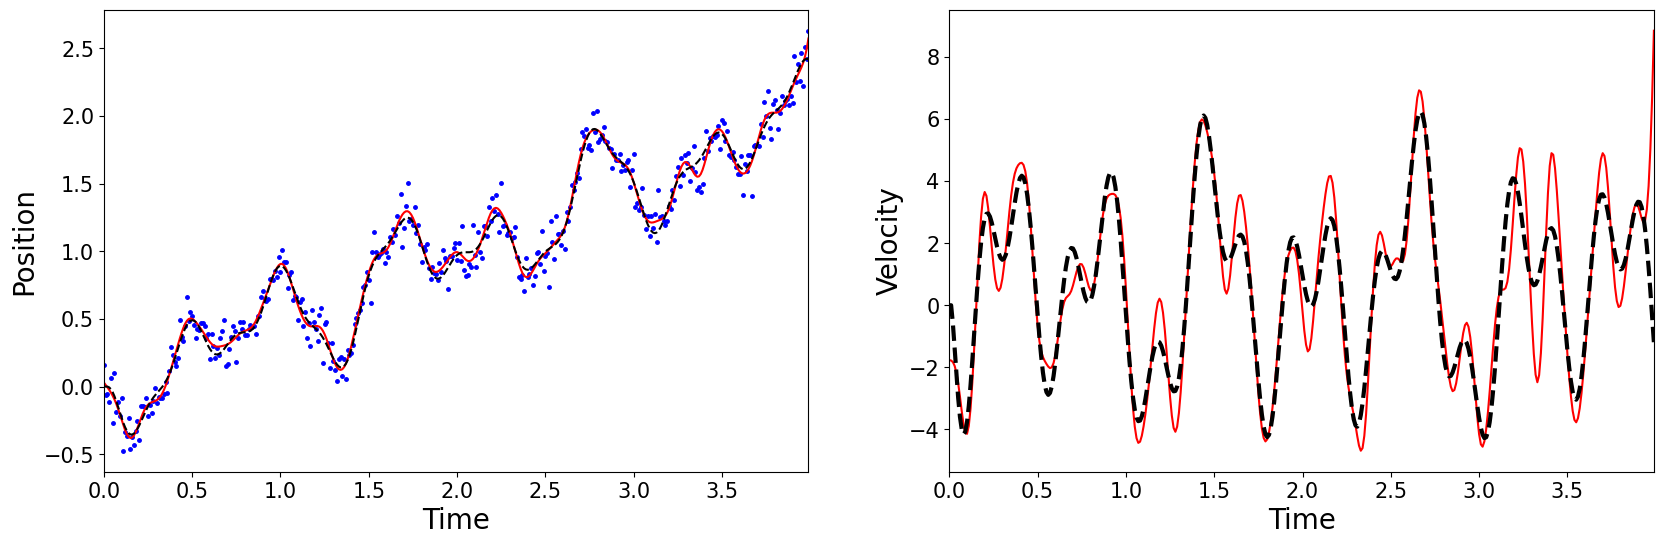

In [23]:
params, val = optimize(constant_jerk, x, dt, search_space={'forwardbackward': [True, False]}, tvgamma=tvgamma)
print('Optimal parameters: ', params)
x_hat, dxdt_hat = constant_jerk(x, dt, **params)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)